Zero-shot classification of disciplines
===============================

Learning materials have educational disciplines (vakgebieden) associated with them. This notebook investigates if a unsupervised learning technique called "zero-shot classification" can be used to determine the discipline of a learning material where none is given.

We assume that a 95% precision is necessary for predictions to be useful.

In [1]:
import torch
from transformers import pipeline
import datasets
from datasets import load_dataset

from sklearn.metrics import classification_report, precision_recall_curve, PrecisionRecallDisplay

In [2]:
datasets.logging.disable_progress_bar()

The data and labels
----------------------------

There are 11 different disciplines that can be assigned to a learning material. One discipline is "interdisciplinairy" and this means that multiple other disciplines apply. For this test we exclude it. We could assign this discipline if a few other disciplines match equally well. However because "interdisciplinairy" as a discipline is not really related to specific content it is not suitable for zero-shot classification.

Data is preprocessed outside of this notebook. A script in the same folder as this notebook named ``dataset.py`` shows how the dataset was constructed from learning materials taken from Sharekit by the Harvester Django project. The data adheres to the following:
* Every material is English, because we're working with an English language model
* Every material has at least one discipline that is not "interdisciplinairy"
* Every material has at least a description which we can use as input for the zero-shot classification


In [9]:
# To do zero-shot classification in English we need the labels to be English
# and hold as much semantic value as possible
discipline_labels = {
    "behaviour or society": "gedrag_maatschappij",
    "law or policy": "recht_bestuur",
    "education": "onderwijs_opvoeding",
    "language or communication": "taal_communicatie",
    "technology": "techniek",
    "health or medicine": "gezondheid",
    "science, engineering, mathematics or computers": "exact_informatica",
    "economy or business": "economie_bedrijf",
    "the planet or the environment" : "aarde_milieu",
    "arts or culture": "kunst_cultuur",
}

In [4]:
data = load_dataset("json", data_files="data.json")

Using custom data configuration default-e4c05ab598ff697e
Found cached dataset json (/home/fako/.cache/huggingface/datasets/json/default-e4c05ab598ff697e/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)


In [5]:
# Lets see what labels we're looking for
data["train"]["discipline"][:10]

[['exact_informatica', 'techniek', 'onderwijs_opvoeding'],
 ['onderwijs_opvoeding', 'exact_informatica', 'techniek'],
 ['onderwijs_opvoeding', 'exact_informatica', 'techniek'],
 ['onderwijs_opvoeding', 'exact_informatica', 'techniek'],
 ['onderwijs_opvoeding', 'exact_informatica', 'techniek'],
 ['onderwijs_opvoeding', 'exact_informatica', 'techniek'],
 ['onderwijs_opvoeding', 'exact_informatica', 'techniek'],
 ['onderwijs_opvoeding', 'exact_informatica', 'techniek'],
 ['onderwijs_opvoeding', 'exact_informatica', 'techniek'],
 ['onderwijs_opvoeding', 'exact_informatica', 'techniek']]

In [6]:
# Merging title and description into an input feature that we can feed to the model
data["train"] = data["train"].map(lambda item: {"input": f"{item['title']}\n\n{item['description']}"})

Parameter 'function'=<function <lambda> at 0x7f4d3ed9f400> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [7]:
# And lets see what kind of input we're going to give to the model
buckets = {
    "0-20": (0, 20,),
    "20-40": (20, 40,),
    "40-60": (40, 60,),
    "60-80": (60, 80,),
    "80-100": (80, 100,),
    "100-120": (100, 120,),
    "120-140": (120, 140,),
    "140-160": (140, 160,),
    "160-180": (160, 180,),
    "180-200": (180, 200,),
}
description_sizes = {
    label: len(data["train"].filter(lambda item: len(item["input"]) > size[0] and len(item["input"]) < size[1]))
    for label, size in buckets.items()
}
description_sizes

{'0-20': 1,
 '20-40': 33,
 '40-60': 103,
 '60-80': 80,
 '80-100': 77,
 '100-120': 78,
 '120-140': 51,
 '140-160': 40,
 '160-180': 50,
 '180-200': 62}

In [8]:
# Based on the buckets and common sense a minimal lenght of 50 for the description seems reasonable.
# That cuts away some of our data, but it's likely to improve results 
# as we'll have to give the classifier something to work with.
longer_input_data = data.filter(lambda item: len(item["input"]) >= 50)

# Even though we're using an unsupervised method, we want some data in a test set 
# to prevent overfitting when determining thresholds.
prepared_data = longer_input_data["train"].train_test_split(test_size=0.1)
prepared_data

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'description', 'text', 'discipline', 'input'],
        num_rows: 1058
    })
    test: Dataset({
        features: ['id', 'title', 'description', 'text', 'discipline', 'input'],
        num_rows: 118
    })
})

Zero-shot model
------------------------

We're using the HuggingFace library with Torch to make things easy for ourselves.
The model we're using is a relatively small model to be able to run it on laptops.

We're saving the output of the model to a local file to prevent having to run the classification repeatedly.
It takes a while to classify 800 examples.

In [10]:
# Loading the model
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Creating classifier on device: {device}")
classifier = pipeline(
    "zero-shot-classification", 
    model="facebook/bart-large-mnli", revision="c626438", 
    device=device
)

Creating classifier on device: cuda:0


In [11]:
# Using the model to predict labels based on description input
predictions = classifier(
    sequences=prepared_data["train"]["input"], 
    candidate_labels=list(discipline_labels.keys()),
    hypothesis_template="This example is about {}."
)

In [12]:
# This cell saves predictions to use them at a later time
import json
with open("predictions-title-description-50.02.json", "w") as json_file:
    json.dump(predictions, json_file, indent=4)

In [13]:
# This cell loads previous predictions if there are any
import json
with open("predictions-title-description-50.02.json", "r") as json_file:
    predictions = [prediction for prediction in json.load(json_file)]

In [14]:
# This is what a pipeline prediction looks like
predictions[0]

{'sequence': '07. What does our cosmic neighbourhood look like?\n\nVideo about our own solar system. After the video you should have an overview over the different objects that make up the solar system, and over the different regions that exist in our solar system.',
 'labels': ['education',
  'behaviour or society',
  'the planet or the environment',
  'language or communication',
  'technology',
  'law or policy',
  'economy or business',
  'science, engineering, mathematics or computers',
  'arts or culture',
  'health or medicine'],
 'scores': [0.1945667266845703,
  0.1649404913187027,
  0.1304250806570053,
  0.12375855445861816,
  0.10048443078994751,
  0.08214417845010757,
  0.06160639226436615,
  0.051294442266225815,
  0.04785768315196037,
  0.042922064661979675]}

Multi-class evaluation
-------------------------------

Our first simple evaluation metric is to one-hot encode the predictions output and look at some metrics.
This is not a great method, because one-hot isn't very suitable for multi-class,
but since we also have some single class data it seems indicative

In [15]:
# Defining some functions that help to evaluate multi-class predictions

labels_list = list(discipline_labels.keys())

def label_vector_from_labels(labels):
    vector = []
    for label in labels_list:
        vector.append(label in labels)
    return vector

def label_vector_from_classes(classes):
    vector = []
    for label in labels_list:
        vector.append(discipline_labels[label] in classes)
    return vector

In [16]:
y_true = [label_vector_from_classes(classes) for classes in prepared_data["train"]["discipline"]]
y_pred = [label_vector_from_labels([prediction["labels"][0]]) for prediction in predictions]
print(classification_report(y_true, y_pred, target_names=labels_list))

                                                precision    recall  f1-score   support

                          behaviour or society       0.20      0.14      0.16       217
                                 law or policy       0.71      0.60      0.65        62
                                     education       0.04      0.24      0.06        25
                     language or communication       0.36      0.39      0.37       212
                                    technology       0.30      0.30      0.30       132
                            health or medicine       0.02      0.05      0.02        22
science, engineering, mathematics or computers       0.04      0.08      0.05        74
                           economy or business       0.78      0.48      0.59       102
                 the planet or the environment       0.57      0.12      0.20       224
                               arts or culture       0.57      0.03      0.07       115

                              

Determining thresholds
----------------------------------

These first results are still pretty far off from where we want them to be. Let's see if we can decide on better thresholds.


The goal for the threshold is to have at least 95% precision with a maximum recall. Given the precisions and recalls for different thresholds we can find which threshold meets our criteria.

In [17]:
# Defining some helper functions to determine thresholds

def binary_labels_and_scores_for_discipline(label):
    y_true = [discipline_labels[label] in classes for classes in prepared_data["train"]["discipline"]]
    y_scores = []
    for prediction in predictions:
        ix = prediction["labels"].index(label)
        y_scores.append(prediction["scores"][ix])
    return y_true, y_scores

def determine_threshold(precisions, recalls, thresholds, minimal_precision=.95):
    optimal_precision = None
    optimal_recall = 0
    optimal_threshold = None

    for prc, rec, thr in zip(precisions, recalls, thresholds):
        if prc < minimal_precision or rec < optimal_recall:
            continue
        optimal_precision = prc
        optimal_recall = rec
        optimal_threshold = thr
    return optimal_precision, optimal_recall, optimal_threshold

In [18]:
y_true, y_scores = binary_labels_and_scores_for_discipline("law or policy")

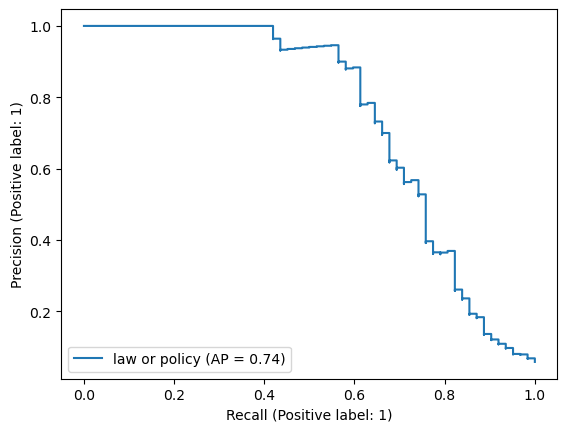

In [19]:
PrecisionRecallDisplay.from_predictions(y_true, y_scores, name="law or policy")

In [20]:
precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)
determine_threshold(precisions, recalls, thresholds)

(0.9642857142857143, 0.43548387096774194, 0.6250482797622681)

First results
-----------------

So for one class we're able to determine that in our data we can set a certain threshold and then it will pick out 41% of those classes while making few errors.

Currently the input is the title and description of a material. It could be interesting to try to add the cleaned Tika text. Another approach would be to add our own "head" to the model. This would require training and that means we'll need more data. We're using a rather small language model at the moment. Moving to a bigger model like Bloom is also expected to yield better results.

In [ ]:
optimal_thresholds = {}
precision_and_recall = {}
for label in discipline_labels:
    y_true, y_scores = binary_labels_and_scores_for_discipline(label)
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)
    precision, recall, threshold = determine_threshold(precisions, recalls, thresholds)
    optimal_thresholds[label] = threshold
    precision_and_recall[label] = [precision, recall]